In [19]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import pickle

In [47]:
class AgentPos:
    def __init__(self, x_pos, y_pos, max) -> None:
        self.x = x_pos
        self.y = y_pos
        self.max = max

    def move_up(self) -> None:
        self.y+=1
        self.y = np.clip(self.y, 0, self.max)

    def move_down(self) -> None:
        self.y-=1
        self.y = np.clip(self.y, 0, self.max)

    def move_right(self) -> None:
        self.x+=1
        self.x = np.clip(self.x, 0, self.max)

    def move_left(self) -> None:
        self.x-=1
        self.x = np.clip(self.x, 0, self.max)


    def check_at_pos(self, pos: tuple) -> bool:
        return self.x == pos[0] and self.y == pos[1]

    def getPosAsTuple(self,) -> tuple:
        return (self.x, self.y)

    def checkAgentWithinGrid(self,) -> bool:
        return self.x >= 0 and self.y >= 0 and self.x <= self.max and self.y <= self.max
    
class GridEnvironment(gym.Env):

    def __init__(self, grid_size, epochs) -> None:
        self.grid_size = grid_size
        self.observation_space = spaces.Box(1,1,(self.grid_size*self.grid_size,))
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = epochs

        self.timestep = 0
        self.agent_pos = AgentPos(0,0, self.grid_size-1)
        self.goal_pos = (self.grid_size - 1, self.grid_size - 1)
        self.state = np.zeros((self.grid_size, self.grid_size))


    def reset(self, seed=4 ):
        self.timestep = 0
        self.state = np.zeros((self.grid_size, self.grid_size))
        self.agent_pos = AgentPos(0,0, self.grid_size-1)
        self.goal_pos = (self.grid_size - 1, self.grid_size - 1)
        self.rewards = {(1,0):-1, (2,1):-5, (3,3):10, (0,2):-2}
        for pos, reward in self.rewards.items():
            self.state[pos] = reward

        self.action_space = spaces.Discrete(4)

        new_state = self.agent_pos.x*self.grid_size + self.agent_pos.y
        
        new_state_arr = np.zeros((16,), dtype=np.float32)
        new_state_arr[new_state] = 1

        info = {}

        return new_state_arr, info

    def reinitState(self,):
        self.state = np.ones((self.grid_size, self.grid_size))

    def setAgentAndTargetPos(self,):
        self.state[tuple(self.agent_pos.getPosAsTuple())] = 0
        self.state[tuple(self.goal_pos)] = 0.5

    def perform_step(self, action):
        if action == 0:
            self.agent_pos.move_up()
        elif action == 1:
            self.agent_pos.move_down()
        elif action == 2:
            self.agent_pos.move_right()
        elif action == 3:
            self.agent_pos.move_left()

        self.reinitState()
        self.setAgentAndTargetPos()

        terminated = False
        if self.agent_pos.check_at_pos(self.goal_pos) or self.timestep>= self.max_timesteps:
            terminated = True

        new_state = self.agent_pos.x*self.grid_size + self.agent_pos.y
        reward=0
        if self.agent_pos.getPosAsTuple() in self.rewards:
            reward = self.rewards[self.agent_pos.getPosAsTuple()]
        

        info = {}

        self.timestep += 1
        
        new_state_arr = np.zeros((16,), dtype=np.float32)
        new_state_arr[new_state] = 1

        return new_state_arr, reward, terminated, False, info

    def render(self,):
        arr = np.zeros(shape=(self.grid_size,self.grid_size))
        plt.clf()
        plt.imshow(arr, cmap="gray", extent=[0, self.grid_size, 0, self.grid_size])

        for pos, reward in self.rewards.items():
            if reward == 10:
                img = "granny.png"
            elif reward == -1:
                img = "thorns.png"
            elif reward == -2:
                img = "tazz.png"
            elif reward == -5:
                img = "elmer.png"
            image = plt.imread(img)
            plt.imshow(image, extent=[pos[0], pos[0]+1, pos[1], pos[1]+1])

        agent_img = "bunny.png"
        pos = self.agent_pos.getPosAsTuple()
        if pos in self.rewards:
            if self.rewards[pos] < 0:
                agent_img = "bugs_cry.png"
            elif self.rewards[pos] > 0:
                agent_img = "bugs_happy.png"
        plt.imshow(plt.imread(agent_img), extent=[pos[0]+0.25, pos[0]+0.75, pos[1]+0.25, pos[1]+0.75])

        plt.xticks(np.arange(0, self.grid_size +1, 1))
        plt.yticks(np.arange(0, self.grid_size +1, 1))
        plt.grid(True, axis='both', color='white', linewidth=1.5)

class DeterministicGridEnvironment(GridEnvironment):

    def __init__(self, grid_size, epochs) -> None:
        super().__init__(grid_size, epochs)

    def step(self, action):
        return self.perform_step(action)

In [20]:
class Network(nn.Module):

    def __init__(self, inp_dim=1, hidden_dims=[16], out_dim=1):
        super(Network, self).__init__()
        layers = [nn.Linear(inp_dim, hidden_dims[0]), nn.ReLU()]
        for i in range( len(hidden_dims)-1):
            layers.extend([nn.Linear(in_features=hidden_dims[i], out_features=hidden_dims[i+1]), nn.ReLU()])
        layers.extend([nn.Linear(hidden_dims[-1],out_dim)])
        self.net = nn.Sequential(*layers)

    def forward(self, input):
          return self.net(input)

In [21]:
def plot_list( arr: list, title: str, x_label: str, y_label: str, plot_label: str):
    plt.clf()
    plt.plot([i+1 for i in range(len(arr))], arr, label=plot_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [90]:
class A2C_Agent():

    def __init__(self, env, max_reward, episodes=10000, discount=0.99, lr_actor=0.001, lr_critic=0.001):
      self.env=env
      self.observation_space = env.observation_space
      self.action_space = env.action_space
      self.obs_shape = self.observation_space.shape
      self.actor = Network(inp_dim=self.obs_shape[0], hidden_dims=[16], out_dim=self.action_space.n)#.cuda()
      self.critic = Network(inp_dim=self.obs_shape[0], hidden_dims=[16], out_dim=1)#.cuda()
      self.discount = discount
      self.episodes = episodes
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
      self.loss_func = nn.MSELoss()
      self.policy_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
      self.value_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_critic)
      self.max_reward=max_reward

    def train(self,):
      tr = np.array([])
      for e in range(self.episodes):

        ep_rewards = []
        actor_estimates = []
        critic_estimates = []
        cur_obs, _ = self.env.reset()
        cur_obs = torch.from_numpy(cur_obs)
        term = False
        trunc = False
        self.policy_optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        while not term and not trunc:

          #Actor estimating the policy
          action_log_probs = Categorical(logits=self.actor(cur_obs))
          action = action_log_probs.sample()

          new_obs, reward, term, trunc, _ = self.env.step(action.item())

          cur_obs = torch.from_numpy(new_obs)

          ep_rewards.append(reward)

          actor_estimates.append(action_log_probs.log_prob(action))

          #Critic estimating the value
          critic_estimates.append(self.critic(cur_obs).squeeze())

        

        tr = np.append(tr, np.sum(ep_rewards))
        for i in range(len(ep_rewards)):
          for j in range(i+1, len(ep_rewards)):
            ep_rewards[i] += self.discount**(j-i) * ep_rewards[j]

        discounted_total_returns = ep_rewards
        
        discounted_total_returns = torch.tensor(discounted_total_returns)#.cuda()
        critic_estimates = torch.stack(critic_estimates)#.cuda()
        actor_estimates = torch.stack(actor_estimates)#.cuda()
        policy_loss = torch.sum(-1*actor_estimates*( discounted_total_returns - critic_estimates.detach()))
        value_loss = self.loss_func(discounted_total_returns, critic_estimates)

        policy_loss.backward()
        value_loss.backward()

        self.policy_optimizer.step()
        self.value_optimizer.step()

        if (e+1)%100 == 0:
            avg_reward = np.mean(tr[e-100:e])
            print("Episode : ", e+1, " Reward : ", np.mean(tr[e-100:e]))
            if avg_reward >= self.max_reward:
              break
      plot_list(tr, "Episodes Vs Rewards", "Episode", "Reward", "Episodes Vs Rewards")

    def test(self, ):
      episode_rewards = []
      rewards = []
      for _ in range(20):
        cur_obs, _ = self.env.reset()
        cur_obs = torch.from_numpy(cur_obs)#.cuda()
        term = False
        trunc = False
        rewards = []
        while not term and not trunc:

          #Actor estimating the policy
          action_log_probs = Categorical(logits=self.actor(cur_obs))
          action = action_log_probs.sample()

          new_obs, reward, term, trunc, _ = self.env.step(action.item())

          cur_obs = torch.from_numpy(new_obs)

          rewards.append(reward)

        episode_rewards.append(np.sum(rewards))
      plot_list(episode_rewards, "Episodes Vs Rewards", "Episode", "Reward", "Episodes Vs Rewards")

Episode :  100  Reward :  nan
Episode :  200  Reward :  10.0


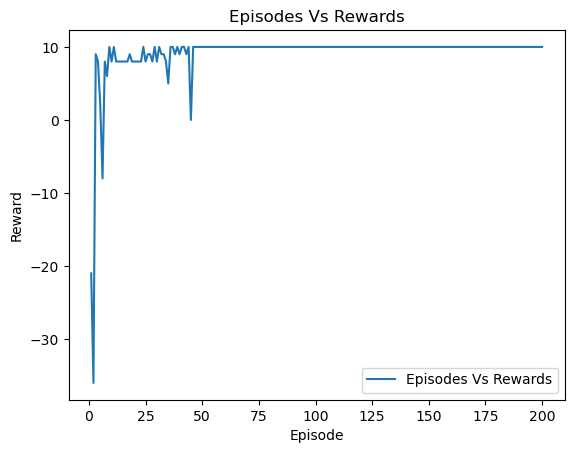

In [97]:
env = DeterministicGridEnvironment(4, 1000)
agent=A2C_Agent(env, max_reward=10, episodes=500, discount=0.99, lr_actor=0.04, lr_critic=0.04)
agent.train()

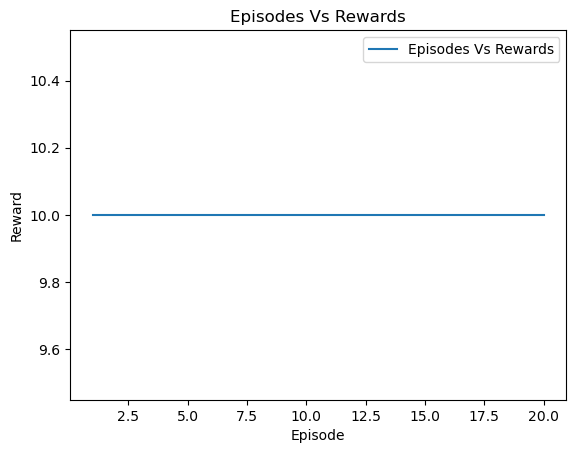

In [98]:
agent.test()

In [99]:
with open('sugheert_hvenkatr_assignment3_gridworld_actor.pkl', 'wb') as f:
            pickle.dump(agent.actor, f)
with open('sugheert_hvenkatr_assignment3_gridworld_critic.pkl', 'wb') as f:
            pickle.dump(agent.critic, f)

Episode :  100  Reward :  nan
Episode :  200  Reward :  85.71
Episode :  300  Reward :  276.84
Episode :  400  Reward :  476.62
Episode :  500  Reward :  452.91
Episode :  600  Reward :  387.12
Episode :  700  Reward :  500.0


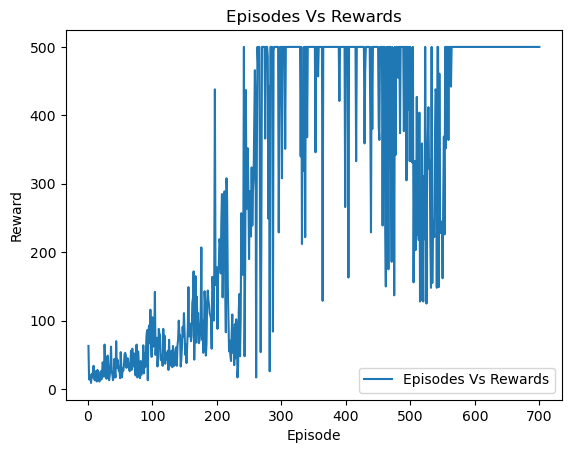

In [100]:
env = gym.make("CartPole-v1")
cartpole_agent=A2C_Agent(env, max_reward=500, episodes=1500, discount=0.99, lr_actor=0.004, lr_critic=0.004)
cartpole_agent.train()

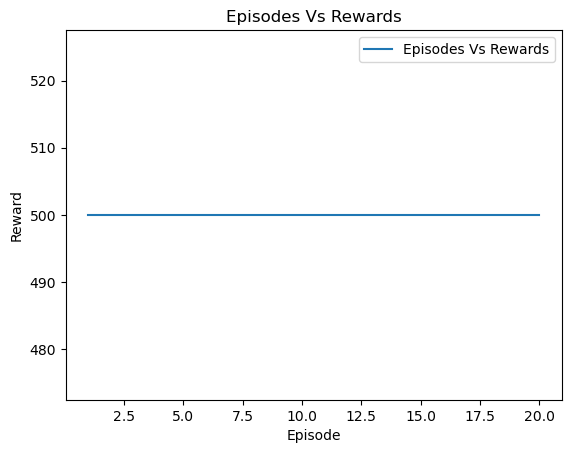

In [101]:
cartpole_agent.test()

In [102]:
with open('sugheert_hvenkatr_assignment3_cartpole_actor.pkl', 'wb') as f:
            pickle.dump(cartpole_agent.actor, f)
with open('sugheert_hvenkatr_assignment3_cartpole_critic.pkl', 'wb') as f:
            pickle.dump(cartpole_agent.critic, f)

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import pickle

class Network(nn.Module):

    def __init__(self, inp_dim=1, hidden_dims=[16], out_dim=1):
        super(Network, self).__init__()
        layers = [nn.Linear(inp_dim, hidden_dims[0]), nn.ReLU()]
        for i in range( len(hidden_dims)-1):
            layers.extend([nn.Linear(in_features=hidden_dims[i], out_features=hidden_dims[i+1]), nn.ReLU()])
        layers.extend([nn.Linear(hidden_dims[-1],out_dim)])
        self.net = nn.Sequential(*layers)

    def forward(self, input):
          return self.net(input)

def plot_list( arr: list, title: str, x_label: str, y_label: str, plot_label: str):
    plt.clf()
    plt.plot([i+1 for i in range(len(arr))], arr, label=plot_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()


class A2C_Agent():

    def __init__(self, env, episodes=10000, discount=0.99, lr_actor=0.001, lr_critic=0.001):
      self.env=env
      self.observation_space = env.observation_space
      self.action_space = env.action_space
      self.obs_shape = self.observation_space.shape
      self.actor = Network(inp_dim=self.obs_shape[0], hidden_dims=[16], out_dim=self.action_space.shape[0])#.cuda()
      self.log_strd_deviations = nn.Parameter(torch.full((self.action_space.shape[0],), 0.1))
      self.critic = Network(inp_dim=self.obs_shape[0], hidden_dims=[16], out_dim=1)#.cuda()
      self.discount = discount
      self.episodes = episodes
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
      self.loss_func = nn.MSELoss()
      self.policy_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
      self.value_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_critic)

    def step(self, action):
      assert self.action_space.contains(action), f"Action {action} is not in the action space"
      position = self.state[0]
      velocity = self.state[1]
      if not isinstance(action, list):
          action = [action]
      force = min(max([action], self.min_action), self.max_action)
      velocity += force * self.power - 0.0025 * math.cos(3 * position)
      velocity = np.clip(velocity, -self.max_speed, self.max_speed)
      position += velocity
      position = np.clip(position, self.min_position, self.max_position)
      if position == self.min_position and velocity < 0:
          velocity = 0
      self.state = np.array([position, velocity])
      terminated = bool(position >= self.goal_position)
      truncated = False
      if self.episode_length >= 999:
        truncated = True

      if terminated:
        reward = 0.0
      else:
        reward = -1.0
      self.episode_length += 1
      return self.state, reward, terminated,truncated, {}

    def reset(self):
      self.state = np.array([np.random.uniform(-0.6, -0.4), 0])
      self.episode_length = 0
      return self.state
    def train(self,):
      tr = np.array([])
      for e in range(self.episodes):

        ep_rewards = []
        actor_estimates = []
        critic_estimates = []
        cur_obs, _ = self.env.reset()
        cur_obs = torch.from_numpy(cur_obs.reshape(1,-1)).float()
        term = False
        trunc = False
        self.policy_optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        while not term and not trunc:

          #Actor estimating the policy
          out = self.actor(cur_obs).float()
          log_strd_deviations = torch.clamp(self.log_strd_deviations.exp(), 1e-3, 1)
          action_log_probs = torch.distributions.Normal(out, log_strd_deviations)
          action = action_log_probs.sample()

          # Here we are Extracting scalar value from action tensor
          action = [action.item()]

          new_obs, reward, term, trunc, _ = self.env.step(action)
          cur_obs = torch.from_numpy(new_obs.reshape(1, -1)).float()
          ep_rewards.append(reward)
          actor_estimates.append(action_log_probs.log_prob(torch.Tensor([action]).squeeze()).squeeze())
          critic_estimates.append(self.critic(cur_obs).squeeze().float())

        tr = np.append(tr, np.sum(ep_rewards))
        for i in range(len(ep_rewards)):
          for j in range(i+1, len(ep_rewards)):
            ep_rewards[i] += self.discount**(j-i) * ep_rewards[j]

        discounted_total_returns = ep_rewards
        discounted_total_returns = torch.tensor(discounted_total_returns).float()#.cuda()
        critic_estimates = torch.stack(critic_estimates)#.cuda()
        actor_estimates = torch.stack(actor_estimates)#.cuda()

        policy_loss = torch.sum(-1*actor_estimates*( discounted_total_returns - critic_estimates.detach()).unsqueeze(dim=-1))
        value_loss = self.loss_func(discounted_total_returns, critic_estimates)

        policy_loss.backward()
        value_loss.backward()

        self.policy_optimizer.step()
        self.value_optimizer.step()

        if e%200 == 0:
            avg_reward = np.mean(tr[e-200:e])
            print("Episode : ", e, " Reward : ", np.mean(tr[e-200:e]))
            if avg_reward >= -100:
              break
      plot_list(tr, "Episodes Vs Rewards", "Episode", "Reward", "Episodes Vs Rewards")

    def save_our_a2c_weights(self, filename='hvenkatr_sugheert_assignment3_part2_MountainCarContinuous.pkl'):
        weights = {
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict()
        }

        with open(filename, 'wb') as f:
            pickle.dump(weights, f)

    def test(self, env):
      episode_rewards = []
      rewards = []
      for _ in range(100):
          cur_obs, _ = self.env.reset()
          cur_obs = torch.from_numpy(cur_obs).float()
          term = False
          trunc = False
          rewards = []
          while not term and not trunc:

              # Actor estimating the policy
              action_mean = self.actor(cur_obs)
              log_strd_deviations = torch.clamp(self.log_strd_deviations.exp(), 1e-3, 1)
              action_std = log_strd_deviations
              action = torch.normal(action_mean, action_std)
              action = [action.item()]
              new_obs, reward, term, trunc, _ = self.env.step(action)
              self.env.render()
              cur_obs = torch.from_numpy(new_obs).float()
              rewards.append(reward)
          episode_rewards.append(np.sum(rewards))
      plot_list(episode_rewards, "Test Episodes Vs Rewards", "Episode", "Reward", "Test Episodes Vs Rewards")

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import pickle

class Network(nn.Module):

    def __init__(self, inp_dim=1, hidden_dims=[16], out_dim=1):
        super(Network, self).__init__()
        layers = [nn.Linear(inp_dim, hidden_dims[0]), nn.ReLU()]
        for i in range( len(hidden_dims)-1):
            layers.extend([nn.Linear(in_features=hidden_dims[i], out_features=hidden_dims[i+1]), nn.ReLU()])
        layers.extend([nn.Linear(hidden_dims[-1],out_dim)])
        self.net = nn.Sequential(*layers)

    def forward(self, input):
          return self.net(input)

def plot_list( arr: list, title: str, x_label: str, y_label: str, plot_label: str):
    plt.clf()
    plt.plot([i+1 for i in range(len(arr))], arr, label=plot_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()


class A2C_Agent():

    def __init__(self, env, episodes=10000, discount=0.99, lr_actor=0.001, lr_critic=0.001):
      self.env=env
      self.observation_space = env.observation_space
      self.action_space = env.action_space
      self.obs_shape = self.observation_space.shape
      self.actor = Network(inp_dim=self.obs_shape[0], hidden_dims=[16], out_dim=self.action_space.shape[0])#.cuda()
      self.log_strd_deviations = nn.Parameter(torch.full((self.action_space.shape[0],), 0.1))
      self.critic = Network(inp_dim=self.obs_shape[0], hidden_dims=[16], out_dim=1)#.cuda()
      self.discount = discount
      self.episodes = episodes
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
      self.loss_func = nn.MSELoss()
      self.policy_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
      self.value_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_critic)

    def step(self, action):
      assert self.action_space.contains(action), f"Action {action} is not in the action space"
      position = self.state[0]
      velocity = self.state[1]
      if not isinstance(action, list):
          action = [action]
      force = min(max([action], self.min_action), self.max_action)
      velocity += force * self.power - 0.0025 * math.cos(3 * position)
      velocity = np.clip(velocity, -self.max_speed, self.max_speed)
      position += velocity
      position = np.clip(position, self.min_position, self.max_position)
      if position == self.min_position and velocity < 0:
          velocity = 0
      self.state = np.array([position, velocity])
      terminated = bool(position >= self.goal_position)
      truncated = False
      if self.episode_length >= 999:
        truncated = True

      if terminated:
        reward = 0.0
      else:
        reward = -1.0
      self.episode_length += 1
      return self.state, reward, terminated,truncated, {}

    def reset(self):
      self.state = np.array([np.random.uniform(-0.6, -0.4), 0])
      self.episode_length = 0
      return self.state
    def train(self,):
      tr = np.array([])
      for e in range(self.episodes):

        ep_rewards = []
        actor_estimates = []
        critic_estimates = []
        cur_obs, _ = self.env.reset()
        cur_obs = torch.from_numpy(cur_obs.reshape(1,-1)).float()
        term = False
        trunc = False
        self.policy_optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        while not term and not trunc:

          #Actor estimating the policy
          out = self.actor(cur_obs).float()
          log_strd_deviations = torch.clamp(self.log_strd_deviations.exp(), 1e-3, 1)
          action_log_probs = torch.distributions.Normal(out, log_strd_deviations)
          action = action_log_probs.sample()

          # Here we are Extracting scalar value from action tensor
          action = [action.item()]

          new_obs, reward, term, trunc, _ = self.env.step(action)
          cur_obs = torch.from_numpy(new_obs.reshape(1, -1)).float()
          ep_rewards.append(reward)
          actor_estimates.append(action_log_probs.log_prob(torch.Tensor([action]).squeeze()).squeeze())
          critic_estimates.append(self.critic(cur_obs).squeeze().float())

        tr = np.append(tr, np.sum(ep_rewards))
        for i in range(len(ep_rewards)):
          for j in range(i+1, len(ep_rewards)):
            ep_rewards[i] += self.discount**(j-i) * ep_rewards[j]

        discounted_total_returns = ep_rewards
        discounted_total_returns = torch.tensor(discounted_total_returns).float()#.cuda()
        critic_estimates = torch.stack(critic_estimates)#.cuda()
        actor_estimates = torch.stack(actor_estimates)#.cuda()

        policy_loss = torch.sum(-1*actor_estimates*( discounted_total_returns - critic_estimates.detach()).unsqueeze(dim=-1))
        value_loss = self.loss_func(discounted_total_returns, critic_estimates)

        policy_loss.backward()
        value_loss.backward()

        self.policy_optimizer.step()
        self.value_optimizer.step()

        if e%200 == 0:
            avg_reward = np.mean(tr[e-200:e])
            print("Episode : ", e, " Reward : ", np.mean(tr[e-200:e]))
            if avg_reward >= -100:
              break
      plot_list(tr, "Episodes Vs Rewards", "Episode", "Reward", "Episodes Vs Rewards")

    def save_our_a2c_weights(self, filename='hvenkatr_sugheert_assignment3_part2_MountainCarContinuous.pkl'):
        weights = {
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict()
        }

        with open(filename, 'wb') as f:
            pickle.dump(weights, f)

    def test(self, env):
      episode_rewards = []
      rewards = []
      for _ in range(100):
          cur_obs, _ = self.env.reset()
          cur_obs = torch.from_numpy(cur_obs).float()
          term = False
          trunc = False
          rewards = []
          while not term and not trunc:

              # Actor estimating the policy
              action_mean = self.actor(cur_obs)
              log_strd_deviations = torch.clamp(self.log_strd_deviations.exp(), 1e-3, 1)
              action_std = log_strd_deviations
              action = torch.normal(action_mean, action_std)
              action = [action.item()]
              new_obs, reward, term, trunc, _ = self.env.step(action)
              self.env.render()
              cur_obs = torch.from_numpy(new_obs).float()
              rewards.append(reward)
          episode_rewards.append(np.sum(rewards))
      plot_list(episode_rewards, "Test Episodes Vs Rewards", "Episode", "Reward", "Test Episodes Vs Rewards")

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode :  0  Reward :  nan
Episode :  200  Reward :  -96.23058930674284


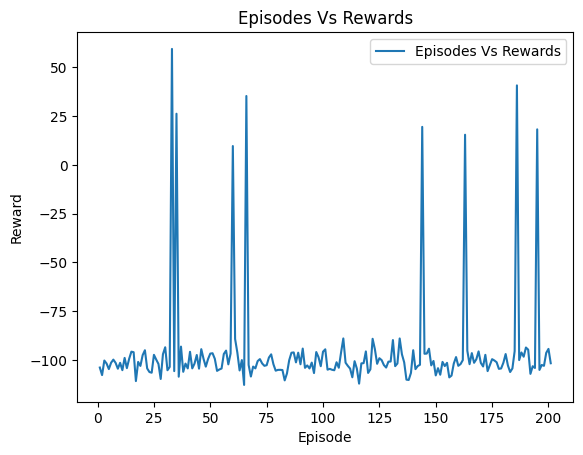

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/continuous_mountain_car.py:197: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
  gym.logger.warn(


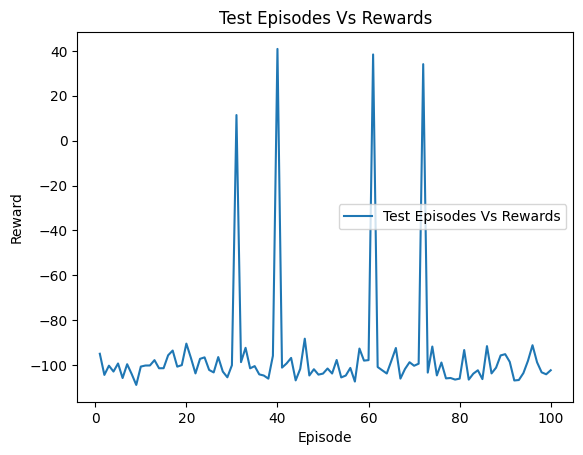

In [ ]:
env = gym.make("MountainCarContinuous-v0",render_mode="human")
agent=A2C_Agent(env, episodes=1500, discount=0.8, lr_actor=0.0005, lr_critic=0.0005)
agent.train()
agent.save_our_a2c_weights()
agent.test()

In [22]:
class A2C_Agent():

    def __init__(self, env, episodes=10000, discount=0.99, lr_actor=0.001, lr_critic=0.001):
      self.env=env
      self.observation_space = env.observation_space
      self.action_space = env.action_space
      self.obs_shape = self.observation_space.shape
      self.actor = Network(inp_dim=self.obs_shape[0], hidden_dims=[256], out_dim=self.action_space.shape[0])#.cuda()
      self.log_strd_deviations = nn.Parameter(torch.full((self.action_space.shape[0],), 0.1))
      self.critic = Network(inp_dim=self.obs_shape[0], hidden_dims=[64], out_dim=1)#.cuda()
      self.discount = discount
      self.episodes = episodes
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
      self.loss_func = nn.MSELoss()
      self.policy_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
      self.value_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_critic)

    def train(self,):
      tr = np.array([])
      for e in range(self.episodes):

        ep_rewards = []
        actor_estimates = []
        critic_estimates = []
        cur_obs, _ = self.env.reset()
        cur_obs = torch.from_numpy(cur_obs.reshape(1,-1)).float()
        term = False
        trunc = False
        self.policy_optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        while not term and not trunc:

          #Actor estimating the policy
          out = self.actor(cur_obs).float()
          log_strd_deviations = torch.clamp(self.log_strd_deviations.exp(), 1e-3, 1)
          action_log_probs = torch.distributions.Normal(out, log_strd_deviations)
          action = action_log_probs.sample()

          new_obs, reward, term, trunc, _ = self.env.step(action.numpy().squeeze())

          cur_obs = torch.from_numpy(new_obs.reshape(1,-1)).float()

          ep_rewards.append(reward)

          actor_estimates.append(action_log_probs.log_prob(action).squeeze())

          #Critic estimating the value
          critic_estimates.append(self.critic(cur_obs).squeeze().float())

        tr = np.append(tr, np.sum(ep_rewards))
        
        for i in range(len(ep_rewards)):
          for j in range(i+1, len(ep_rewards)):
            ep_rewards[i] += self.discount**(j-i) * ep_rewards[j]

        discounted_total_returns = torch.tensor(ep_rewards).float()#.cuda()
        critic_estimates = torch.stack(critic_estimates)#.cuda()
        actor_estimates = torch.stack(actor_estimates)#.cuda()
        policy_loss = torch.sum(-1*actor_estimates*( discounted_total_returns - critic_estimates.detach()).unsqueeze(dim=-1))
        value_loss = self.loss_func(discounted_total_returns, critic_estimates)

        policy_loss.backward()
        value_loss.backward()

        self.policy_optimizer.step()
        self.value_optimizer.step()

        if e%100 == 0:
            avg_reward = np.mean(tr[e-100:e])
            print("Episode : ", e, " Reward : ", np.mean(tr[e-100:e]))
            if avg_reward >= 300:
              break
      plot_list(tr, "Episodes Vs Rewards", "Episode", "Reward", "Episodes Vs Rewards")

    def test(self, env):
      episode_rewards = []
      rewards = []
      for _ in range(20):
        cur_obs, _ = env.reset()
        cur_obs = torch.from_numpy(cur_obs.reshape(1,-1)).float()#.cuda()
        term = False
        trunc = False
        rewards = []
        while not term and not trunc:

          #Actor estimating the policy
          out = self.actor(cur_obs).float()
          log_strd_deviations = torch.clamp(self.log_strd_deviations.exp(), 1e-3, 1)
          action_log_probs = torch.distributions.Normal(out, log_strd_deviations)
          action = action_log_probs.sample()

          new_obs, reward, term, trunc, _ = env.step(action.numpy().squeeze())

          cur_obs = torch.from_numpy(new_obs.reshape(1,-1)).float()

          rewards.append(reward)

        episode_rewards.append(np.sum(rewards))
      plot_list(episode_rewards, "Episodes Vs Rewards", "Episode", "Reward", "Episodes Vs Rewards")

In [10]:
!pip install swig

  Obtaining dependency information for swig from https://files.pythonhosted.org/packages/d0/ef/44fb7b4216530551460666286ec04424d34f4a25e8fba1cebe742a24e012/swig-4.2.1-py2.py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
    --------------------------------------- 0.1/2.6 MB 825.8 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/2.6 MB 2.2 MB/s eta 0:00:02
   ----------- ---------------------------- 0.7/2.6 MB 4.5 MB/s eta 0:00:01
   ------------- -------------------------- 0.9/2.6 MB 4.9 MB/s eta 0:00:01
   ------------------------ --------------- 1.6/2.6 MB 6.7 MB/s eta 0:00:01
   ------------------------- -------------- 1.6/2.6 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 7.7 MB/s eta 0:00:00


In [11]:
!pip install box2d

     ---------------------------------------- 0.0/427.9 kB ? eta -:--:--
     ---------------------------------------- 0.0/427.9 kB ? eta -:--:--
     ---------------------------------------- 0.0/427.9 kB ? eta -:--:--
      --------------------------------------- 10.2/427.9 kB ? eta -:--:--
     --- --------------------------------- 41.0/427.9 kB 653.6 kB/s eta 0:00:01
     --- --------------------------------- 41.0/427.9 kB 653.6 kB/s eta 0:00:01
     --- --------------------------------- 41.0/427.9 kB 653.6 kB/s eta 0:00:01
     --- --------------------------------- 41.0/427.9 kB 653.6 kB/s eta 0:00:01
     ------- ----------------------------- 81.9/427.9 kB 286.7 kB/s eta 0:00:02
     ------- ----------------------------- 81.9/427.9 kB 286.7 kB/s eta 0:00:02
     ------- ----------------------------- 92.2/427.9 kB 238.1 kB/s eta 0:00:02
     --------- -------------------------- 112.6/427.9 kB 261.9 kB/s eta 0:00:02
     ------------ ----------------------- 143.4/427.9 kB 293.9 kB/s

In [12]:
!pip install box2d-py

     ---------------------------------------- 0.0/374.5 kB ? eta -:--:--
     -- ------------------------------------- 20.5/374.5 kB ? eta -:--:--
     --- --------------------------------- 30.7/374.5 kB 445.2 kB/s eta 0:00:01
     --- --------------------------------- 30.7/374.5 kB 445.2 kB/s eta 0:00:01
     --------------- -------------------- 163.8/374.5 kB 984.6 kB/s eta 0:00:01
     --------------------- ---------------- 215.0/374.5 kB 1.0 MB/s eta 0:00:01
     --------------------------- ---------- 266.2/374.5 kB 1.1 MB/s eta 0:00:01
     --------------------------------- ---- 327.7/374.5 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 374.5/374.5 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp311-cp311-win_amd64.whl size=433150 sha256=a12b6287ec31a42fd84e775578eccadd1d50717210305f4d7d0960a81097f141
  Stored in directory: c:\u

In [13]:
!pip install gymnasium[box2d]

     ---------------------------------------- 0.0/374.4 kB ? eta -:--:--
     -- ---------------------------------- 20.5/374.4 kB 640.0 kB/s eta 0:00:01
     ------- ----------------------------- 71.7/374.4 kB 787.7 kB/s eta 0:00:01
     --------------------- ---------------- 215.0/374.4 kB 1.6 MB/s eta 0:00:01
     -------------------------------------- 374.4/374.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for pygame>=2.1.3 from https://files.pythonhosted.org/packages/82/61/93ae7afbd931a70510cfdf0a7bb0007540020b8d80bc1d8762ebdc46479b/pygame-2.5.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   - -------------------------------------- 0.4/10.8 MB 26.6 MB/s eta 0:00:01
   ---- ----------------------------------- 1.1/10.8 MB 13.8 MB/s eta 0:00:01
   ---- ----------------------------------- 1.2/10.8 MB 10.9 MB/s 

Episode :  0  Reward :  nan
Episode :  100  Reward :  -111.97752780793618
Episode :  200  Reward :  -111.45734579189188
Episode :  300  Reward :  -107.8142147080378
Episode :  400  Reward :  -108.14960052324432
Episode :  500  Reward :  -104.16455664518004
Episode :  600  Reward :  -100.3078044334942
Episode :  700  Reward :  -96.17226355343097
Episode :  800  Reward :  -90.46165289822561
Episode :  900  Reward :  -83.9074515031856
Episode :  1000  Reward :  -79.40950557805658
Episode :  1100  Reward :  -79.39365947804242
Episode :  1200  Reward :  -78.00602522299064
Episode :  1300  Reward :  -76.5747064360776
Episode :  1400  Reward :  -81.64706530364597
Episode :  1500  Reward :  -85.29776454684028
Episode :  1600  Reward :  -74.56801362926505
Episode :  1700  Reward :  -74.59454848007545
Episode :  1800  Reward :  -81.3148618625609
Episode :  1900  Reward :  -78.58020670297675
Episode :  2000  Reward :  -74.60546082475543
Episode :  2100  Reward :  -71.37922706417152
Episode :  220

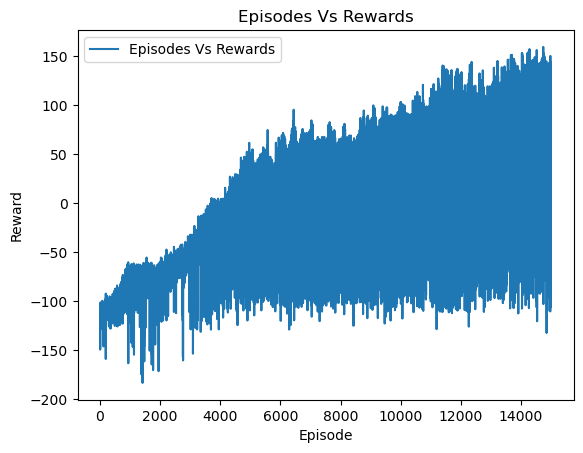

In [77]:
env = gym.make("BipedalWalker-v3")
agent=A2C_Agent(env, episodes=15000, discount=0.99, lr_actor=0.0001, lr_critic=0.0001)
agent.train()

In [79]:
import pickle
with open('sugheert_hvenkatr_assignment3_bipedal_walker_actor.pkl', 'wb') as f:
            pickle.dump(agent.actor, f)
with open('sugheert_hvenkatr_assignment3_bipedal_walker_critic.pkl', 'wb') as f:
            pickle.dump(agent.critic, f)

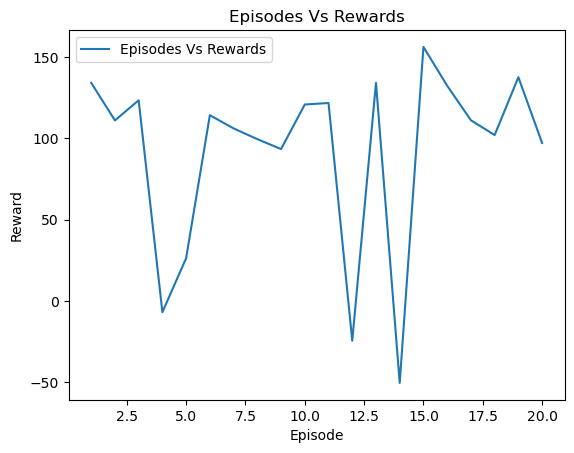

In [33]:
import pickle

with open('sugheert_hvenkatr_assignment3_bipedal_walker_actor.pkl', "rb") as infile:
    new_actor = pickle.load(infile)
with open('sugheert_hvenkatr_assignment3_bipedal_walker_critic.pkl', 'rb') as infile:
    new_critic = pickle.load(infile)

env = gym.make("BipedalWalker-v3")
new_agent = A2C_Agent(env, episodes=4000, discount=0.99, lr_actor=0.01, lr_critic=0.01)
new_agent.actor = new_actor
new_agent.critic = new_critic

new_agent.test(env)

As we saw some scope for improvement, we tried retraining the model for 4000 more episodes

Episode :  0  Reward :  nan
Episode :  100  Reward :  82.88630063475131
Episode :  200  Reward :  96.4177594044829
Episode :  300  Reward :  86.10482934157872
Episode :  400  Reward :  97.53742675646207
Episode :  500  Reward :  83.75475003636063
Episode :  600  Reward :  87.56589667885592
Episode :  700  Reward :  89.09363255246087
Episode :  800  Reward :  83.22540095887473
Episode :  900  Reward :  98.5805371100077
Episode :  1000  Reward :  91.96581702907268
Episode :  1100  Reward :  83.45896559930004
Episode :  1200  Reward :  83.58659509384519
Episode :  1300  Reward :  83.59598344873588
Episode :  1400  Reward :  82.43084124575242
Episode :  1500  Reward :  98.23514061711225
Episode :  1600  Reward :  97.11262051845306
Episode :  1700  Reward :  83.80802721824499
Episode :  1800  Reward :  90.663968347961
Episode :  1900  Reward :  96.7423533275773
Episode :  2000  Reward :  90.38618594797217
Episode :  2100  Reward :  85.07248084685027
Episode :  2200  Reward :  85.55418890712

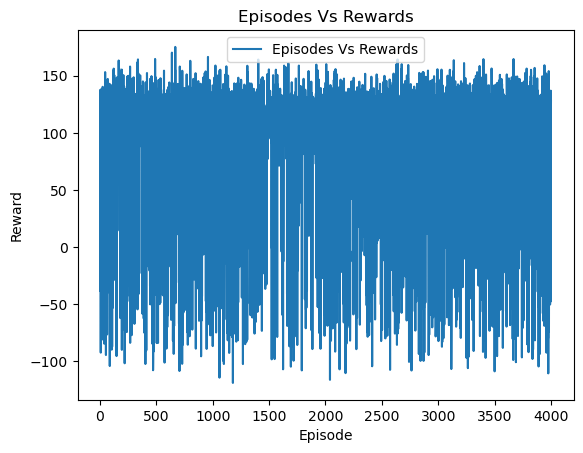

In [18]:
import pickle

with open('sugheert_hvenkatr_assignment3_bipedal_walker_actor.pkl', "rb") as infile:
    new_actor = pickle.load(infile)
with open('sugheert_hvenkatr_assignment3_bipedal_walker_critic.pkl', 'rb') as infile:
    new_critic = pickle.load(infile)

env = gym.make("BipedalWalker-v3")
new_agent = A2C_Agent(env, episodes=4000, discount=0.99, lr_actor=0.01, lr_critic=0.01)
new_agent.actor = new_actor
new_agent.critic = new_critic

new_agent.train()

Complex Image Based Environment - CarRacing

In [12]:
from torchvision import transforms
class ImageNetwork(nn.Module):
    def __init__(self, obs_shape, action_size, k1, s1, k2, s2):
        super(ImageNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 4, out_channels = 32, kernel_size = k1, stride=s1  ) # 10 5 41 31
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = k2, stride=s2) # 7 2 18 13
        conv1_out_shape = (np.array(obs_shape) - self.conv1.kernel_size)//self.conv1.stride + 1
        conv2_out_shape = (conv1_out_shape - self.conv2.kernel_size)//self.conv2.stride + 1 
        self.fc1 = nn.Linear(16*conv2_out_shape.prod(), action_size)
        self.act_func = nn.functional.relu
        self.preprocess = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
            ])
        
    def forward(self, inp):
        out = self.act_func(self.conv1(inp))
        out = self.act_func(self.conv2(out))
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out
    
class ActorImgNet(ImageNetwork):
    def __init__(self, obs_shape, action_size, k1, s1, k2, s2):
        super().__init__(obs_shape, action_size, k1, s1, k2, s2)
        self.log_strd_deviations = nn.Parameter(torch.full((action_size,), 0.1))
        
    def forward(self, inp):
        out = super().forward(inp)
        lsd = torch.clamp(self.log_strd_deviations.exp(), 1e-3, 1)
        return torch.distributions.Normal(out, lsd)
    
class CriticImageNet(ImageNetwork):
    def __init__(self, obs_shape, k1, s1, k2, s2):
        super().__init__(obs_shape, 1, k1, s1, k2, s2)
        
    def forward(self, inp):
        out = super().forward(inp)
        return out
        

In [40]:
from collections import deque
from PIL import Image

class A2C_Img_Agent():

    def __init__(self, env, episodes=10000, discount=0.99, lr_actor=0.001, lr_critic=0.001):
      self.env=env
      self.observation_space = env.observation_space
      self.action_space = env.action_space
      self.obs_shape = self.observation_space.shape
      self.actor = ActorImgNet(obs_shape=self.observation_space.shape[:2], action_size=self.action_space.shape[0], k1=8, s1=4, k2=5, s2=2).cuda()
      self.critic = CriticImageNet(obs_shape=self.observation_space.shape[:2], k1=8, s1=4, k2=5, s2=2).cuda()
      self.discount = discount
      self.episodes = episodes
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
      self.loss_func = nn.MSELoss()
      self.policy_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
      self.value_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_critic)

    def train(self,):
      tr = np.array([])
      for e in range(self.episodes):

        ep_rewards = []
        actor_estimates = []
        critic_estimates = []
        cur_obs, _ = self.env.reset()
        cur_obs = self.actor.preprocess(Image.fromarray(cur_obs)).squeeze(axis=0).numpy()
        cur_state_stack = np.array([], dtype=np.float32)
        for _ in range(4):
          np.append(cur_state_stack, cur_obs)
        state_dq=deque([cur_obs, cur_obs, cur_obs, cur_obs], maxlen=4)
        cur_state_stack = np.array(state_dq, dtype=np.float32)
        cur_state_tensor = torch.from_numpy(np.expand_dims(cur_state_stack, axis=0)).cuda()
        term = False
        trunc = False
        self.policy_optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        while not term and not trunc:

          #Actor estimating the policy
          action_log_probs = self.actor(cur_state_tensor)
          action = action_log_probs.sample()

          new_obs, reward, term, trunc, _ = self.env.step(action.cpu().numpy().squeeze())

          ep_rewards.append(reward)

          actor_estimates.append(action_log_probs.log_prob(action).squeeze())

          #Critic estimating the value
          critic_estimates.append(self.critic(cur_state_tensor).squeeze().float())
           
          state_dq.append(self.actor.preprocess(Image.fromarray(new_obs)).squeeze(axis=0).numpy())
          cur_state_stack = np.array(state_dq, dtype=np.float32)

        tr = np.append(tr, np.sum(ep_rewards))
       
        discounted_total_returns = ep_rewards
        last_but_one = len(discounted_total_returns)-1
        
        for i in range(last_but_one):
            discounted_total_returns[last_but_one-1-i] += self.discount*discounted_total_returns[last_but_one-i]

        discounted_total_returns = torch.tensor(discounted_total_returns).float().cuda()
        critic_estimates = torch.stack(critic_estimates).cuda()
        actor_estimates = torch.stack(actor_estimates).cuda()
        policy_loss = torch.sum(-1*actor_estimates*( discounted_total_returns - critic_estimates.detach()).unsqueeze(dim=-1))
        value_loss = self.loss_func(discounted_total_returns, critic_estimates)

        policy_loss.backward()
        value_loss.backward()

        self.policy_optimizer.step()
        self.value_optimizer.step()

        if e%100 == 0:
            avg_reward = np.mean(tr[e-100:e])
            print("Episode : ", e, " Reward : ", np.mean(tr[e-100:e]))
            if avg_reward >= 900:
              break
        print("e: ", e, "r: ", tr[-1])
      plot_list(tr, "Episodes Vs Rewards", "Episode", "Reward", "Episodes Vs Rewards")

    def test(self, env):
      
      episode_rewards = []
      rewards = []
      for e in range(20):
        rewards = []
        cur_obs, _ = env.reset()
        cur_obs = self.actor.preprocess(Image.fromarray(cur_obs)).squeeze(axis=0).numpy()
        cur_state_stack = np.array([], dtype=np.float32)
        for _ in range(4):
          np.append(cur_state_stack, cur_obs)
        state_dq=deque([cur_obs, cur_obs, cur_obs, cur_obs], maxlen=4)
        cur_state_stack = np.array(state_dq, dtype=np.float32)
        cur_state_tensor = torch.from_numpy(np.expand_dims(cur_state_stack, axis=0)).cuda()
        term = False
        trunc = False
        while not term and not trunc:

          #Actor estimating the policy
          action_log_probs = self.actor(cur_state_tensor)
          action = action_log_probs.sample()

          new_obs, reward, term, trunc, _ = env.step(action.cpu().numpy().squeeze())
          rewards.append(reward)
          
          state_dq.append(self.actor.preprocess(Image.fromarray(new_obs)).squeeze(axis=0).numpy())
          cur_state_stack = np.array(state_dq, dtype=np.float32)
        episode_rewards.append(np.sum(rewards))
      plot_list(episode_rewards, "Episodes Vs Rewards", "Episode", "Reward", "Episodes Vs Rewards")

c:\Users\ssugh\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ssugh\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode :  0  Reward :  nan
e:  0 r:  -57.894736842105964
e:  1 r:  -55.55555555555638
e:  2 r:  -68.7500000000006
e:  3 r:  -66.32996632996696
e:  4 r:  -67.50902527075873
e:  5 r:  -66.88741721854376
e:  6 r:  -71.33757961783472
e:  7 r:  -70.03745318352088
e:  8 r:  -70.03745318352085
e:  9 r:  -79.94269340974182
e:  10 r:  -76.35135135135125
e:  11 r:  -75.00000000000001
e:  12 r:  -64.14342629482144
e:  13 r:  -72.22222222222244
e:  14 r:  -63.76811594202979
e:  15 r:  -73.13432835820917
e:  16 r:  -70.26022304832759
e:  17 r:  -70.58823529411809
e:  18 r:  -66.5427509293687
e:  19 r:  -70.58823529411808
e:  20 r:  -75.75757575757588
e:  21 r:  -65.87030716723629
e:  22 r:  -66.66666666666735
e:  23 r:  -67.42671009772035
e:  24 r:  -67.21311475409884
e:  25 r:  -66.555183946489
e:  26 r:  -67.85714285714326
e:  27 r:  -76.51006711409384
e:  28 r:  -71.87500000000037
e:  29 r:  -70.69597069597114
e:  30 r:  -71.15384615384636
e:  31 r:  -72.69624573378856
e:  32 r:  -74.8427672955

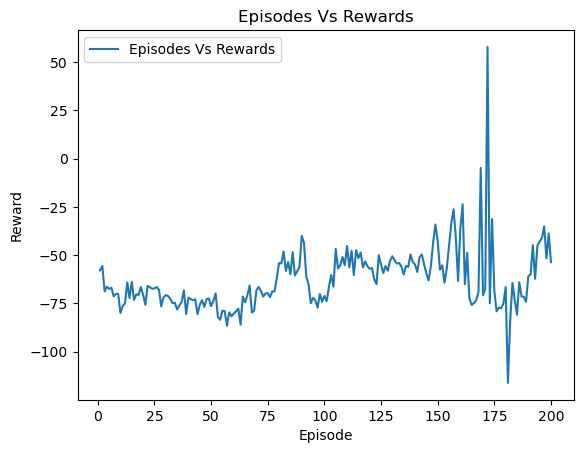

In [36]:
env = gym.make("CarRacing-v2", domain_randomize=False)
racer_agent = A2C_Img_Agent(env, 200, 0.99, 0.0005, 0.0005)
racer_agent.train()

In [38]:
import pickle
with open('sugheert_hvenkatr_assignment3_carracing_actor.pkl', 'wb') as f:
            pickle.dump(racer_agent.actor, f)
with open('sugheert_hvenkatr_assignment3_carracing_critic.pkl', 'wb') as f:
            pickle.dump(racer_agent.critic, f)

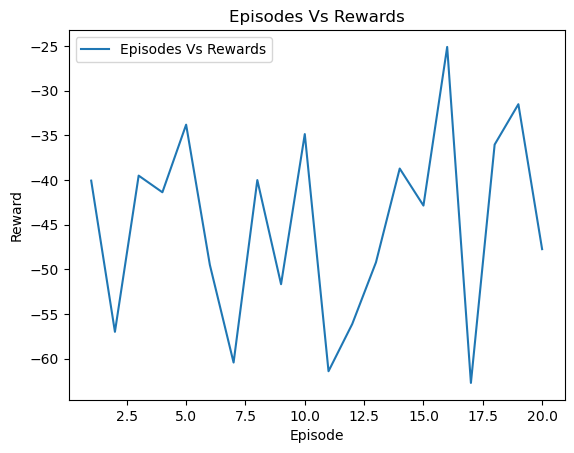

In [42]:
import pickle

with open('sugheert_hvenkatr_assignment3_carracing_actor.pkl', "rb") as infile:
    new_actor = pickle.load(infile)
with open('sugheert_hvenkatr_assignment3_carracing_critic.pkl', 'rb') as infile:
    new_critic = pickle.load(infile)

env = gym.make("CarRacing-v2", domain_randomize=False)
new_agent = A2C_Img_Agent(env, episodes=4000, discount=0.99, lr_actor=0.01, lr_critic=0.01)
new_agent.actor = new_actor
new_agent.critic = new_critic

new_agent.test(env)